In [1]:
import pandas as pd
import numpy as np
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from keras.models import Sequential, Model
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,Input
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import balanced_accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Reshape, Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from keras.callbacks import EarlyStopping

In [2]:
base_dir = "MachineLearningCSV/MachineLearningCVE"

csv_files = os.listdir(base_dir)

data_list = []
for file in csv_files:
  print("Read in {}".format(file))
  data_list.append((pd.read_csv(os.path.join(base_dir, file))))
data = pd.concat(data_list, ignore_index=True)
print("Finished reading in {} entries".format(str(data.shape[0])))

Read in Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Read in Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Read in Friday-WorkingHours-Morning.pcap_ISCX.csv
Read in Monday-WorkingHours.pcap_ISCX.csv
Read in Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Read in Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Read in Tuesday-WorkingHours.pcap_ISCX.csv
Read in Wednesday-workingHours.pcap_ISCX.csv
Finished reading in 2830743 entries


In [3]:
data[" Label"] = data[" Label"].apply(unidecode)

In [4]:
data[" Label"].value_counts(normalize=True)

 Label
BENIGN                       0.803004
DoS Hulk                     0.081630
PortScan                     0.056144
DDoS                         0.045227
DoS GoldenEye                0.003636
FTP-Patator                  0.002804
SSH-Patator                  0.002083
DoS slowloris                0.002048
DoS Slowhttptest             0.001943
Bot                          0.000695
Web Attack  Brute Force      0.000532
Web Attack  XSS              0.000230
Infiltration                 0.000013
Web Attack  Sql Injection    0.000007
Heartbleed                   0.000004
Name: proportion, dtype: float64

In [5]:
selected_feature=[' Flow Duration',' Bwd Packet Length Std', ' Average Packet Size', ' Flow IAT Std',' Label']

In [6]:
new_df=data[selected_feature]

In [7]:
selected_labels = ['DDoS', 'BENIGN']

In [8]:
filtered_df = new_df[new_df[' Label'].isin(selected_labels)]
filtered_df.shape

(2401124, 5)

In [9]:
class_counts = filtered_df[" Label"].value_counts()

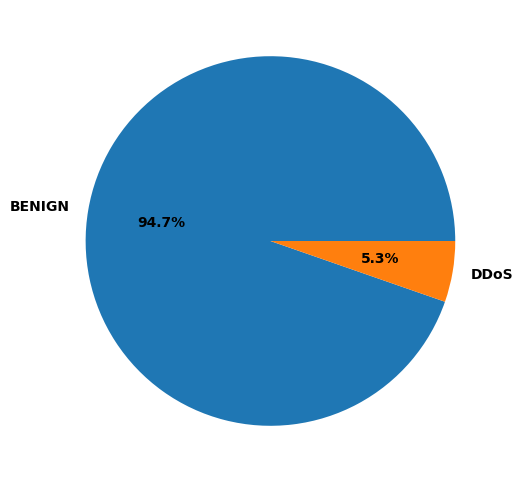

In [10]:
plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.show()

In [11]:
df=filtered_df.dropna(axis=0, how='any')

In [12]:
df = df.replace(',,', np.nan, inplace=False)

In [13]:
df_clean = df.replace([np.inf, -np.inf], np.nan)

In [14]:
for column in df_clean:
    count = df_clean[column].isna().sum()
    print("In column {} the percentage of NaN is {} %".format(column, (count/df_clean.shape[0])*100 ))

In column  Flow Duration the percentage of NaN is 0.0 %
In column  Bwd Packet Length Std the percentage of NaN is 0.0 %
In column  Average Packet Size the percentage of NaN is 0.0 %
In column  Flow IAT Std the percentage of NaN is 0.0 %
In column  Label the percentage of NaN is 0.0 %


In [15]:
print("Total columns before deleting {}".format(df_clean.shape[1]))

for column in df_clean:
    count = (df_clean[column] == 0).sum()
    percent_of_zeros = (count/df_clean.shape[0])*100
    #if(percent_of_zeros >= 70):
    #    print('Perc of zeros in Column  {} is {} %: '.format(column, percent_of_zeros))
    if(percent_of_zeros >= 99.0):
        print("Column deleted: {}".format(column))
        df_clean.drop(column, inplace=True, axis=1)
    
print("Total rows: {}".format(df_clean.shape[0]))
print("Total columns after deleting: {}" .format(df_clean.shape[1]))

Total columns before deleting 5
Total rows: 2401124
Total columns after deleting: 5


In [16]:
df_clean.shape

(2401124, 5)

In [17]:
print("Number of rows before deleting rows {}".format(df_clean.shape[0]))
for column in df_clean:
    df_clean = df_clean[df_clean[column] != -1]

print("Number of rows after deleting rows {}".format(df_clean.shape[0]))
print("Percentage of deleted rows: {} %".format(((df.shape[0]-df_clean.shape[0])/df.shape[0])*100))

Number of rows before deleting rows 2401124
Number of rows after deleting rows 2401015
Percentage of deleted rows: 0.00453954064846297 %


In [18]:
df_clean.shape

(2401015, 5)

In [19]:
df_clean[df_clean[' Label'] == 'DDoS'].shape

(128027, 5)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
df_shuffled = df_clean.sample(frac=1, random_state=42)
split_ratio = 0.76
model_data, gan_data = train_test_split(df_shuffled, test_size=(1 - split_ratio), random_state=42)

In [21]:
gan_data[gan_data[' Label'] == 'DDoS'].shape

(30691, 5)

In [22]:
model_data.to_csv("data_training.csv")

In [23]:
X = model_data[list(model_data.columns)]
y = model_data.loc[:, model_data.columns == " Label"]
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.8, random_state=42)

In [25]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('validation', X_val.shape, y_val.shape)
print('GAN  training data', gan_data[gan_data[' Label'] == 'DDoS'].shape)

Train (1459816, 5) (1459816, 1)
Test (291964, 5) (291964, 1)
validation (72991, 5) (72991, 1)
GAN  training data (30691, 5)


In [26]:
scaler = MinMaxScaler()

In [27]:
cols_X = X_train.select_dtypes(include=['float64','int64']).columns
cols_test_X = X_test.select_dtypes(include=['float64','int64']).columns
sc_train_X = scaler.fit_transform(X_train.select_dtypes(include=['float64','int64']))
sc_test_X = scaler.fit_transform(X_test.select_dtypes(include=['float64','int64']))
sc_traindf_X = pd.DataFrame(sc_train_X, columns = cols_X)
sc_testdf_X = pd.DataFrame(sc_test_X, columns = cols_test_X)

cols_x_val=X_val.select_dtypes(include=['float64','int64']).columns
sc_val_X=scaler.fit_transform(X_val.select_dtypes(include=['float64','int64']))
sc_valdf_x=pd.DataFrame(sc_val_X, columns = cols_x_val)

In [28]:
sc_traindf_X.head()

,Flow Duration,Bwd Packet Length Std,Average Packet Size,Flow IAT Std
0,5.833333e-08,0.000000,0.007962,0.000000e+00
1,2.565583e-04,0.264439,0.331821,1.240752e-04
2,7.265508e-02,0.142791,0.125398,2.794371e-02
3,1.214167e-05,0.000000,0.025000,1.204913e-05
4,5.750000e-07,0.000000,0.002055,5.253254e-07


In [29]:
sc_testdf_X.head()

,Flow Duration,Bwd Packet Length Std,Average Packet Size,Flow IAT Std
0,0.043596,0.04042,0.041096,2.112564e-02
1,0.000793,0.00000,0.000000,0.000000e+00
2,0.000163,0.00000,0.047089,0.000000e+00
3,0.000001,0.00000,0.016010,4.664639e-07
4,0.000002,0.00000,0.010873,1.008944e-06


In [30]:
sc_valdf_x.head()

,Flow Duration,Bwd Packet Length Std,Average Packet Size,Flow IAT Std
0,0.984717,0.0,0.000000,4.528737e-02
1,0.000001,0.0,0.028992,9.980100e-07
2,0.000001,0.0,0.000000,0.000000e+00
3,0.000601,0.0,0.001849,4.240537e-04
4,0.000406,0.0,0.025621,3.311361e-04


In [31]:
labelencoder = LabelEncoder()
y_train_encoded = labelencoder.fit_transform(y_train)
y_train_encoded
# enc = OneHotEncoder()
# y_train_encoded = y_train_encoded.reshape(-1, 1)  # Reshape to 2D
# y_train_onehot = enc.fit_transform(y_train_encoded).toarray()

# # y_train_onehot now contains the one-hot encoded labels
# y_train_onehot.shape

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 0, ..., 0, 0, 0])

In [32]:
y_val_encoded = labelencoder.fit_transform(y_val)
y_val_encoded
# y_val_encoded = y_val_encoded.reshape(-1, 1)  # Reshape to 2D
# y_val_onehot = enc.fit_transform(y_val_encoded).toarray()

# # y_train_onehot now contains the one-hot encoded labels
# y_val_onehot.shape

array([0, 0, 0, ..., 0, 0, 0])

# Hyperparameter selection code

In [33]:
# # Import packages
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, Dropout
# from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.wrappers.scikit_learn import KerasClassifier
# from math import floor
# from sklearn.metrics import make_scorer, accuracy_score
# from bayes_opt import BayesianOptimization
# from sklearn.model_selection import StratifiedKFold
# from keras.layers import LeakyReLU
# LeakyReLU = LeakyReLU(alpha=0.1)
# import warnings
# warnings.filterwarnings('ignore')
# pd.set_option("display.max_columns", None)

In [34]:
# def train_and_evaluate_model(model):

#     model.fit(sc_traindf_X, y_train_onehot, epochs=10, batch_size=32, validation_data=(sc_valdf_x, y_val_onehot))
#     _, accuracy = model.evaluate(sc_valdf_x, y_val_onehot)

#     return accuracy

In [35]:
# def custom_nn_cl_bo(learning_rate, dropout_rate):
#     optimizer = Adam(learning_rate=learning_rate)
#     model = Sequential([
#         Dense(128, input_dim=4, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(64, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(32, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(16, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(2, activation='sigmoid')
#     ])

#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    
#     # Train your model here and return the metric you want to optimize
#     # For demonstration, let's assume you train the model and get some metric like accuracy
#     accuracy = train_and_evaluate_model(model)
    
#     return accuracy

# # Define the parameter ranges for Bayesian Optimization
# params_custom_nn = {
#     'learning_rate': (0.01, 1),
#     'dropout_rate': (0, 0.3)
# }

# # Run Bayesian Optimization
# custom_nn_bo = BayesianOptimization(custom_nn_cl_bo, params_custom_nn, random_state=111)
# custom_nn_bo.maximize(init_points=25, n_iter=4)

# # Get the optimized parameters
# params_custom_nn_optimized = custom_nn_bo.max['params']
# params_custom_nn_optimized['optimizer'] = Adam(learning_rate=params_custom_nn_optimized['learning_rate'])
# params_custom_nn_optimized

# Hyper parameter selection code END here

In [36]:
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_val

In [37]:
learning_rate = 0.001  # Adjust this value as needed
drop_out=.05
# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
modeld = keras.Sequential([
    keras.layers.Dense(128, input_dim=4, activation='relu'),
    keras.layers.Dropout(drop_out),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(drop_out),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(drop_out),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(drop_out),
    keras.layers.Dense(1, activation='sigmoid')
])

modeld.compile(loss='binary_crossentropy', optimizer=optimizer, metrics="accuracy")

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [39]:

history = modeld.fit(sc_traindf_X, y_train_encoded, epochs=50, batch_size=300,
                      validation_data=(sc_valdf_x, y_val_encoded), callbacks=[early_stop])
# history=modeld.fit(sc_traindf_X, y_train_encoded, epochs=50, batch_size=700,validation_data=(sc_valdf_x, y_val_encoded))

Epoch 1/50
4867/4867 [==============================] - 32s 6ms/step - loss: 0.0509 - accuracy: 0.9841 - val_loss: 0.0334 - val_accuracy: 0.9879
Epoch 2/50
4867/4867 [==============================] - 36s 7ms/step - loss: 0.0279 - accuracy: 0.9903 - val_loss: 0.0311 - val_accuracy: 0.9875
Epoch 3/50
4867/4867 [==============================] - 32s 7ms/step - loss: 0.0169 - accuracy: 0.9947 - val_loss: 0.0178 - val_accuracy: 0.9945
Epoch 4/50
4867/4867 [==============================] - 32s 7ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0218 - val_accuracy: 0.9929
Epoch 5/50
4867/4867 [==============================] - 32s 7ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0395 - val_accuracy: 0.9856
Epoch 6/50
4867/4867 [==============================] - 32s 6ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0215 - val_accuracy: 0.9928
Epoch 7/50
4867/4867 [==============================] - 33s 7ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0256 - val_ac

In [40]:
y_test_encoded = labelencoder.fit_transform(y_test)
y_test_encoded
# enc = OneHotEncoder()
# y_test_encoded = y_test_encoded.reshape(-1, 1)  # Reshape to 2D
# y_test_onehot = enc.fit_transform(y_test_encoded).toarray()

# # y_train_onehot now contains the one-hot encoded labels
# y_test_onehot.shape

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0])

In [41]:
modeld.evaluate(sc_testdf_X, y_test_encoded)

9124/9124 [==============================] - 29s 3ms/step - loss: 0.0158 - accuracy: 0.9952


[0.015793491154909134, 0.9951843619346619]

In [42]:
y_pred = modeld.predict(sc_testdf_X)

9124/9124 [==============================] - 16s 2ms/step


In [43]:
y_pred = np.round(y_pred)

In [44]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [45]:

y_pred_1d = np.squeeze(y_pred).astype(int)

# Print the resulting 1D array
print(y_pred_1d)

[0 0 0 ... 0 0 0]


In [46]:
y_test_encoded

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
precision = precision_score(y_test_encoded, y_pred_1d,average='weighted')
recall = recall_score(y_test_encoded, y_pred_1d,average='weighted')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9952928950898247
Recall: 0.9951843377950707


In [48]:
print(classification_report(y_test_encoded, y_pred_1d))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    276432
           1       0.94      0.97      0.96     15532

    accuracy                           1.00    291964
   macro avg       0.97      0.98      0.98    291964
weighted avg       1.00      1.00      1.00    291964



In [49]:
# y_test_binary = np.argmax(y_test_encoded, axis=1)
# y_pred_binary = np.argmax(y_pred_1d, axis=1)
# Assuming y_true contains true labels and y_pred contains predicted labels
balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred_1d)
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.9842707259487965


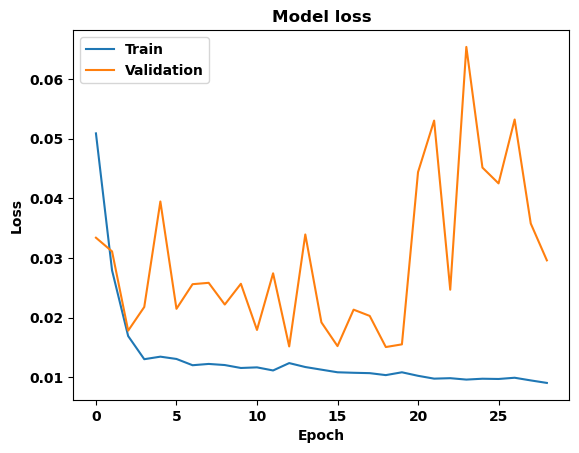

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
# modeld.save("dnn_model.h5")

In [52]:
# y_pred_class = np.argmax(y_pred_1d, axis=1)
# y_true_class = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test_encoded, y_pred_1d)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[275460    972]
 [   434  15098]]


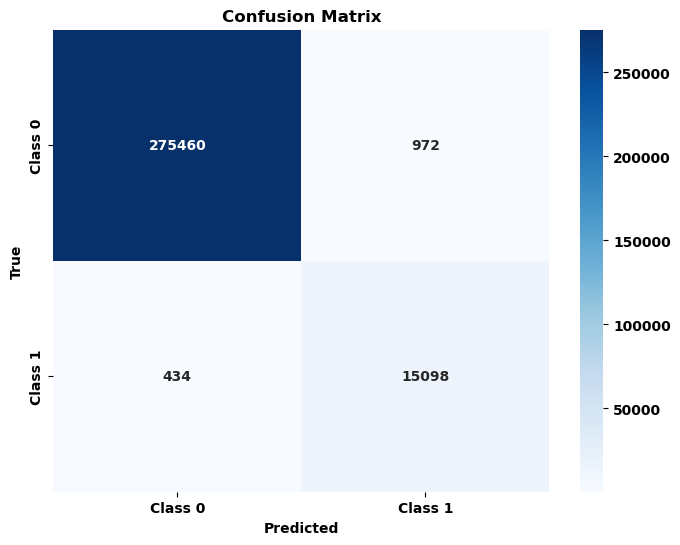

In [53]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_encoded, y_pred_1d)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

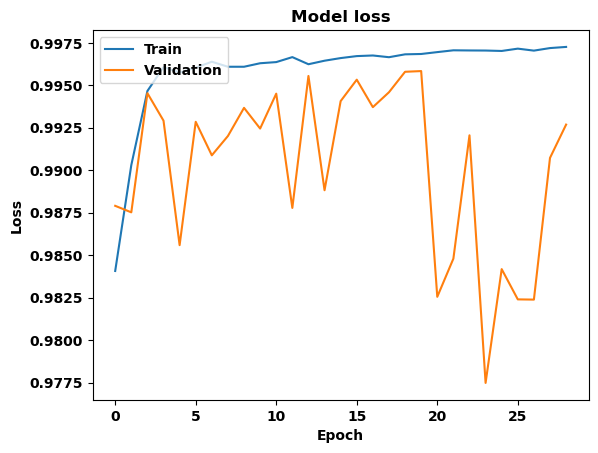

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# with open('history.pkl', 'wb') as file:
#     pickle.dump(history, file)

In [56]:
file_path = 'gan_data.csv'
gan_data.to_csv(file_path, index=False)

In [57]:
gan_data1=gan_data[gan_data[' Label'] == 'DDoS']

In [58]:
gan_data1[" Label"] = 1

C:\Users\Aswin\AppData\Local\Temp\ipykernel_13828\3144654024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gan_data1[" Label"] = 1


In [59]:
cols_gan_data1 = gan_data1.drop(' Label', axis=1).select_dtypes(include=['float64','int64']).columns
sc_gan_data1 = scaler.fit_transform(gan_data1.drop(' Label', axis=1).select_dtypes(include=['float64','int64']))
sc_gan_data1 = pd.DataFrame(sc_gan_data1, columns=cols_gan_data1)

In [60]:
sc_gan_data1.shape

(30691, 4)

In [61]:
file_path = 'pgd_data.csv'
sc_gan_data1.to_csv(file_path, index=False)

In [62]:
sc_gan_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0    Flow Duration          30691 non-null  float64
 1    Bwd Packet Length Std  30691 non-null  float64
 2    Average Packet Size    30691 non-null  float64
 3    Flow IAT Std           30691 non-null  float64
dtypes: float64(4)
memory usage: 959.2 KB


In [63]:
modeld.save("modeld.h5")

In [107]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod,BasicIterativeMethod, ProjectedGradientDescent

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))